# Memory Based Classification with KDM

A memory based classifier with  [Kernel Density Matrices](https://github.com/fagonzalezo/kdm).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics


import numpy as np
import matplotlib.pyplot as plt

import kdm


In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun_mem(clf):
    def pred_fun(X):
        X_ds = clf.create_predict_ds(X)
        return clf.predict(X_ds)[:, 1]
    return pred_fun

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun



## Shallow Memory KDM Model



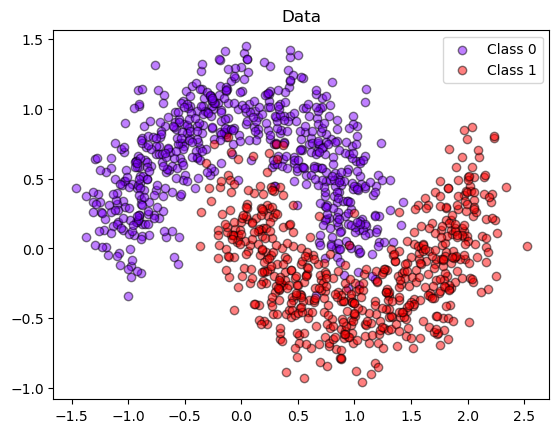

In [3]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

plot_data(X_train, y_train)

In [4]:
# reload kdm.models to get the updated version

from kdm.models.mem_kdm_class_model_wrapper import MemKDMClassModelWrapper

import importlib
importlib.reload(kdm.models.mem_kdm_class_model_wrapper)
importlib.reload(kdm.models)


encoded_size = 2
encoder = keras.layers.Identity()
dim_y = 2
n_comp = 200

mkdm_model = MemKDMClassModelWrapper(
                encoded_size=encoded_size,
                dim_y=dim_y,
                samples_x=X_train,
                samples_y=y_train,
                encoder=encoder,
                n_comp=n_comp,
                sigma=0.1)

mkdm_model.init_sigma(mult=1)


0.3828534889948678

Test Accuracy: 0.96
Validation Accuracy: 0.9575


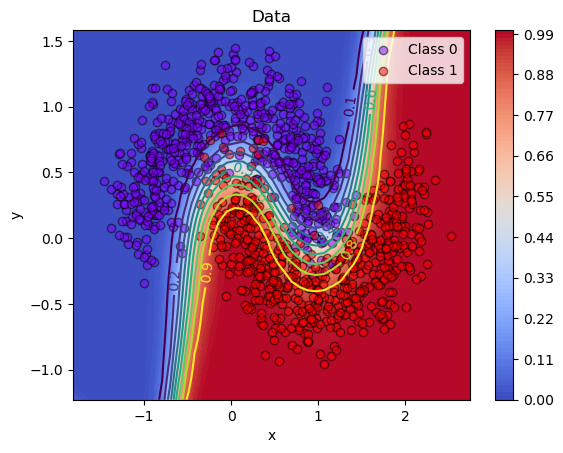

In [5]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

pred_y = mkdm_model.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)

We can fine tune the sigma parameter.

In [6]:

# callbacks
from keras.callbacks import ModelCheckpoint


mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

checkpoint = ModelCheckpoint("model.weights.h5", 
                             monitor='sparse_categorical_accuracy', 
                             save_weights_only=True,
                             save_best_only=True, 
                             mode='max')


print(f"Initial sigma: {mkdm_model.model.kernel.sigma.numpy()}")


mkdm_model.fit(X_val, y_val, epochs=50, verbose=0, callbacks=[checkpoint])

mkdm_model.model.load_weights("model.weights.h5")

print(f"Final sigma: {mkdm_model.model.kernel.sigma.numpy()}")


Initial sigma: 0.3884012997150421
Final sigma: 0.18870685994625092


Test Accuracy: 0.9675
Validation Accuracy: 0.97


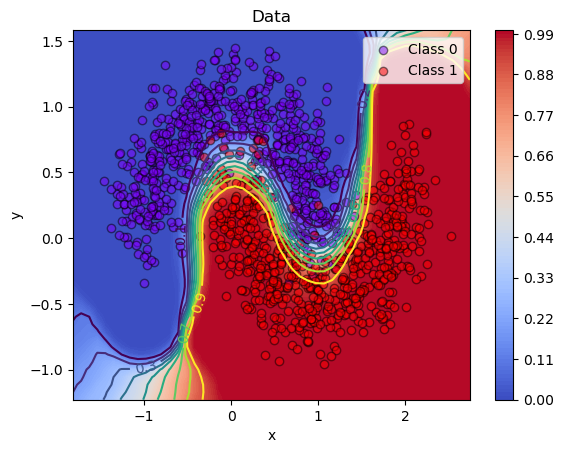

In [7]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

pred_y = mkdm_model.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)

## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [6]:
# Create a dataset from mnist using tf
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [7]:
tfkl = keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = keras.Sequential([
        tfkl.InputLayer(shape=input_shape),
        tfkl.Lambda(lambda x: x - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfkl.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [15]:
from kdm.models import KDMClassModel

# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 64
encoder1 = create_encoder(input_shape, base_depth, encoded_size)

# warm up the encoder
enc_model = keras.Sequential([encoder1,
                keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

# Compile the model
kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM train accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - loss: 0.6777 - sparse_categorical_accuracy: 0.7524
Base encoder test accuracy: 0.8666999936103821
Base encoder train accuracy: 0.8792083263397217
Sigma: 1.6525752544403076
KDM test accuracy: 0.6956999897956848
KDM train accuracy: 0.703374981880188
Sigma: 1.6525752544403076


In [16]:
# create callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                           mode='max', verbose=1, restore_best_weights=True)

# Train the model
kdm_mnist.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=2, batch_size=128, verbose=1,
              callbacks=[earlystop])
# Evaluate the classifier
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM train accuracy:', score[1])
score = kdm_mnist.evaluate(X_val, y_val, verbose=0)
print('KDM validation accuracy:', score[1])
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM test accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.8161 - val_loss: 0.3481 - val_sparse_categorical_accuracy: 0.8838
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - loss: 0.3217 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.3151 - val_sparse_categorical_accuracy: 0.8926
Restoring model weights from the end of the best epoch: 2.
KDM train accuracy: 0.9105833172798157
KDM validation accuracy: 0.8925833106040955
KDM test accuracy: 0.8906000256538391
Sigma: 1.956291675567627


The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

In [18]:
from kdm.models.mem_kdm_class_model_wrapper import MemKDMClassModelWrapper

import importlib
importlib.reload(kdm.models.mem_kdm_class_model_wrapper)
importlib.reload(kdm.models)


n_comp = 200

mkdm_mnist = MemKDMClassModelWrapper(
                encoded_size=encoded_size,
                dim_y=dim_y,
                samples_x=X_train,
                samples_y=y_train,
                encoder=encoder1,
                n_comp=n_comp,
                index_type="OPQ32,IVF1024_HNSW,PQ32",
                sigma=0.1)

mkdm_mnist.init_sigma(mult=1)


9.563882827758789

In [19]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_mnist.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

pred_y = mkdm_mnist.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

Validation Accuracy: 0.7566666666666667
Test Accuracy: 0.7501


Initial sigma: 9.563882827758789
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.8074 - sparse_categorical_accuracy: 0.6841
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7384 - sparse_categorical_accuracy: 0.7027
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7124 - sparse_categorical_accuracy: 0.7264
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.6733 - sparse_categorical_accuracy: 0.7562
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7783
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5949 - sparse_categorical_accuracy: 0.8008
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.8250
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5546 - sparse_categorical_accuracy: 0.8417
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.8559
Epoch 10/10
3

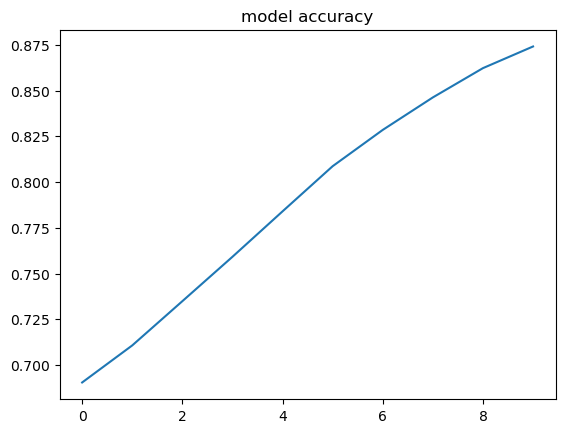

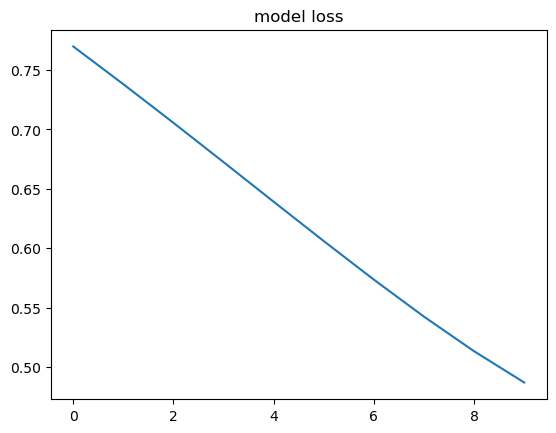

In [20]:
mkdm_mnist.compile(optimizer=optimizers.AdamW(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

earlystop = EarlyStopping(monitor='sparse_categorical_accuracy', patience=5,
                           mode='max', verbose=1, restore_best_weights=True)

print(f"Initial sigma: {mkdm_mnist.model.kernel.sigma.numpy()}")


history = mkdm_mnist.fit(X_val, y_val, epochs=10, verbose=1, callbacks=[earlystop])

print(f"Final sigma: {mkdm_mnist.model.kernel.sigma.numpy()}")

plt.title('model accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.show()
plt.title('model loss')
plt.plot(history.history['loss'])
plt.show()


In [21]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_mnist.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

pred_y = mkdm_mnist.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))



Validation Accuracy: 0.8555833333333334
Test Accuracy: 0.8531
